In [1]:
!pip install -q osmnx

In [2]:
import graph_search_algorithm_compilation
import matplotlib.pyplot as plt
import networkx as nx
import random
import time
import osmnx as ox

# from joblib import Parallel, delayed
from tqdm import tqdm
from dask.distributed import Client
from dask import delayed, compute

In [3]:
if 'client' in globals():
    client.close()
client = Client()

/opt/conda/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35345 instead
  warnings.warn(
2024-10-24 12:36:58,887 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:39027 (pid=338) exceeded 95% memory budget. Restarting...
2024-10-24 12:36:59,157 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:39027' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'evaluate_algorithm-9b4bd0c6-bce2-4e1c-9f66-683c0757c392'} (stimulus_id='handle-worker-cleanup-1729773419.1568696')
2024-10-24 12:37:04,862 - distributed.nanny - WARNING - Restarting worker
2024-10-24 12:37:34,235 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:39381 (pid=327) exceeded 95% memory budget. Restarting...
2024-10-24 12:37:34,510 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:39381' caused the cluster

In [4]:
# Generate a random weighted graph for the simulation
def generate_random_graph(num_nodes, prob=0.1, max_weight=10):
    G = nx.gnp_random_graph(num_nodes, prob, directed=False)
    for (u, v) in G.edges():
        G.edges[u, v]['weight'] = random.randint(1, max_weight)
    return G

In [5]:
# Apply flood conditions to the graph
def apply_flood_conditions(G, flood_probability):
    flooded_edges = []
    for u, v in list(G.edges()):
        if random.random() < flood_probability:
            flooded_edges.append((u, v))
            G.remove_edge(u, v)  # Remove the flooded edges from the graph
    return G

In [6]:
algorithms = {
    "Dijkstra": graph_search_algorithm_compilation.dijkstra_search,
    "Floyd-Warshall": graph_search_algorithm_compilation.floyd_warshall_search,
    "Bellman-Ford": graph_search_algorithm_compilation.bellman_ford_search,
    "Bidirectional": graph_search_algorithm_compilation.bidirectional_search,
    "Dynamic": graph_search_algorithm_compilation.dynamic_shortest_path,
    # "D* Lite": graph_search_algorithm_compilation.d_star_lite,
    "A* Search": graph_search_algorithm_compilation.a_star_search,
    # "MCTS": graph_search_algorithm_compilation.monte_carlo_tree_search,
    "Yen's K-Shortest Paths": graph_search_algorithm_compilation.yen_k_shortest_paths,
    # "ACO": graph_search_algorithm_compilation.ant_colony_optimization,
}

In [7]:
# Parallel execution using Dask
@delayed
def evaluate_algorithm(algorithm_func, G, source, target):
    start_time = time.time()
    try:
        # Call the algorithm with (G, source, target, weight)
        path = algorithm_func(G, source, target, weight='weight')
        duration = time.time() - start_time
        if path is None:
            return float('inf'), []  # Infinite cost for no path found
        return duration, path  # Return computation time and the path
    except Exception as e:
        return float('inf'), []  # Infinite cost for errors


# Run algorithms in parallel using Dask
def run_in_parallel(algorithms, G, source, target):
    delayed_results = [evaluate_algorithm(algo_func, G.copy(), source, target) 
                       for algo_func in algorithms.values()]
    results = compute(*delayed_results)
    return results


# Monte Carlo Simulation: Run all algorithms in parallel on the same graph
def monte_carlo_simulation(G, num_iterations, flood_probability):
    algorithm_performance = {name: [] for name in algorithms.keys()}  # Track performance for each algorithm

    G = apply_flood_conditions(G, flood_probability)
    # Generate the graph and apply flood conditions once

    source = random.choice(list(G.nodes()))
    target = random.choice(list(G.nodes()))

    # Ensure source and target are not the same
    while source == target:
        target = random.choice(list(G.nodes()))

    # Step 4: Evaluate all algorithms in parallel over the same graph, flooded conditions, and source/target
    for _ in tqdm(range(num_iterations)):
        results = run_in_parallel(algorithms, G, source, target)

        # Store results in performance dictionary
        for algo_name, result in zip(algorithms.keys(), results):
            algorithm_performance[algo_name].append(result)

    return algorithm_performance

In [8]:
# Choose the best algorithm based on the performance and return the best result
def choose_best_algorithm(algorithm_performance):
    # Calculate average performance for each algorithm
    avg_performance = {
        algo: sum(duration for duration, _ in times) / len(times)
        for algo, times in algorithm_performance.items()
    }

    # Select the algorithm with the lowest average time
    best_algorithm = min(avg_performance, key=avg_performance.get)

    # Output the performance of all algorithms
    print(f"Best algorithm: {best_algorithm}")
    for algo, avg_time in avg_performance.items():
        print(f"{algo}: {avg_time:.4f} seconds (average)")

    # Return the best algorithm and its last run output (path)
    best_run = algorithm_performance[best_algorithm][-1]  # Get the last run result
    return best_algorithm, best_run[1]  # Return the algorithm name and its path

In [9]:
# Monte Carlo Simulation Parameters
iterations = 1000  # Number of Monte Carlo iterations
graph_size = 50    # Number of nodes in the graph
flooded_road_probability = 0.1  # Probability that a road gets flooded

In [10]:
G = generate_random_graph(graph_size)
while not nx.is_connected(G):
    G = generate_random_graph(graph_size)
G = apply_flood_conditions(G, flooded_road_probability)

In [11]:
# Run the simulation
algorithm_performance = monte_carlo_simulation(G, iterations, flooded_road_probability)

100%|██████████| 1000/1000 [00:49<00:00, 20.04it/s]


Best algorithm: Bidirectional
Dijkstra: 0.0002 seconds (average)
Floyd-Warshall: 0.0242 seconds (average)
Bellman-Ford: 0.0031 seconds (average)
Bidirectional: 0.0000 seconds (average)
Dynamic: 0.0001 seconds (average)
A* Search: 0.0002 seconds (average)
Yen's K-Shortest Paths: inf seconds (average)
Best path found by Bidirectional: [19, 14, 39]


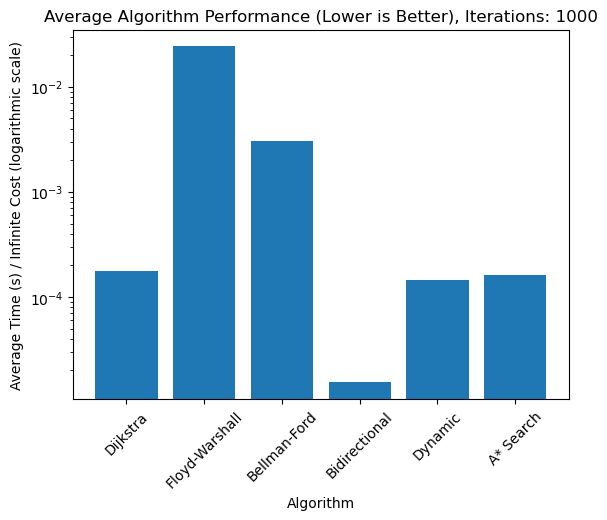

In [12]:
# Choose the best algorithm based on performance
best_algorithm, best_path = choose_best_algorithm(algorithm_performance)

# Display the best algorithm's path
print(f"Best path found by {best_algorithm}: {best_path}")

# Plot the average performance
average_performance = {
    algo: sum(duration for duration, _ in times) / len(times)
    for algo, times in algorithm_performance.items()
}
plt.bar(average_performance.keys(), average_performance.values())
plt.title(f"Average Algorithm Performance (Lower is Better), Iterations: {iterations}")
plt.yscale('log')
plt.xlabel("Algorithm")
plt.ylabel("Average Time (s) / Infinite Cost (logarithmic scale)")
plt.xticks(rotation=45)
plt.show()

### Import Graph of Metro Manila


In [23]:
# bounding box for Metro Manila
NORTH_BBOX = 14.7430
SOUTH_BBOX = 14.4560
WEST_BBOX = 120.9306
EAST_BBOX = 121.1353

In [24]:
METRO_MANILA_BOUNDING_BOX = (NORTH_BBOX, SOUTH_BBOX, EAST_BBOX, WEST_BBOX)

In [25]:
metro_manila_graph = ox.graph_from_bbox(bbox=METRO_MANILA_BOUNDING_BOX)

/tmp/ipykernel_290/3628828398.py:1: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  metro_manila_graph = ox.graph_from_bbox(bbox=METRO_MANILA_BOUNDING_BOX)


In [27]:
ox.save_graphml(metro_manila_graph, '../graphs/graphml/metro_manila_graph.graphml')

In [13]:
fp = '../graphs/graphml/metro_manila_graph.graphml'
metro_manila_graph = ox.load_graphml(fp)

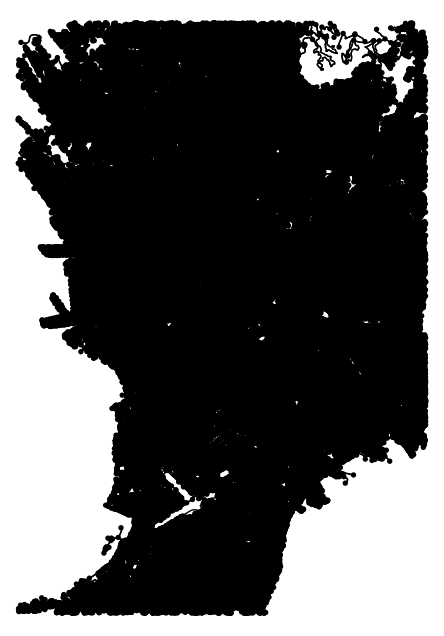

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [26]:
ox.plot_graph(metro_manila_graph, bgcolor='#ffffff', node_color='#000000', edge_color='#000000')

In [15]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(metro_manila_graph)

In [16]:
gdf_nodes.head()

,y,x,street_count,highway,ref,geometry
osmid,,,,,,
12067302,14.541506,120.994972,3,NaN,NaN,POINT (120.99497 14.54151)
12067308,14.537867,120.995733,3,NaN,NaN,POINT (120.99573 14.53787)
12067317,14.540634,120.992152,3,NaN,NaN,POINT (120.99215 14.54063)
12067327,14.556251,120.988315,3,NaN,NaN,POINT (120.98831 14.55625)
12067330,14.559643,120.987132,4,traffic_signals,NaN,POINT (120.98713 14.55964)


In [17]:
path = graph_search_algorithm_compilation.bidirectional_search(metro_manila_graph, 12067302, 12067308)
path

[12067302,
 2950125788,
 5354424837,
 24785165,
 5651175582,
 25388521,
 8317435077,
 25389123,
 25388522,
 978165773,
 445413656,
 8562405196,
 12067308]

#### Monte Carlo with Graph of Metro Manila

In [18]:
iterations = 2
flooded_road_probability = 0.1
algorithm_performance = monte_carlo_simulation(metro_manila_graph, iterations, flooded_road_probability)

  0%|          | 0/2 [00:00<?, ?it/s]/opt/conda/lib/python3.11/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 246.01 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
2024-10-24 12:36:50,662 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.44 GiB -- Worker memory limit: 7.64 GiB
2024-10-24 12:36:54,250 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 6.12 GiB -- Worker memory limit: 7.64 GiB
2024-10-24 12:37:25,295 - distribu

KilledWorker: Attempted to run task 'evaluate_algorithm-3cba3d95-461e-4018-99d9-17d6bff9bd21' on 4 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://127.0.0.1:33021. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

In [ ]:
# Choose the best algorithm based on performance
best_algorithm, best_path = choose_best_algorithm(algorithm_performance)

# Display the best algorithm's path
print(f"Best path found by {best_algorithm}: {best_path}")

# Plot the average performance
average_performance = {
    algo: sum(duration for duration, _ in times) / len(times)
    for algo, times in algorithm_performance.items()
}
plt.bar(average_performance.keys(), average_performance.values())
plt.title(f"Average Algorithm Performance (Lower is Better), Iterations: {iterations}")
plt.yscale('log')
plt.xlabel("Algorithm")
plt.ylabel("Average Time (s) / Infinite Cost (logarithmic scale)")
plt.xticks(rotation=45)
plt.show()

### Conclusion